##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Better performance with the tf.data API

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data_performance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

GPUs and TPUs can radically reduce the time required to execute a single training step.
Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished.
The `tf.data` API helps to build flexible and efficient input pipelines.
This document demonstrates how to use the `tf.data` API's features for building highly performant TensorFlow input pipelines.

Before you continue, read the "[Build TensorFlow input pipelines](./data.ipynb)" guide, to know how to use the `tf.data` API.

## Resources

* [Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* `tf.data.Dataset` API

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import time
import itertools

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

All along this guide, you iterate across a dataset and use returned items to do some computations.
Each step of the iterations is time-measured to show how optimization improve the running times.
To provide such measurement, build an artificial example.

### The dataset

Define a class inheriting from `tf.data.Dataset` called `TimeMeasuredDataset`.
This dataset must:
- generate as much samples as required (default is 3)
- return the time at which steps started and the step duration

In [3]:
class TimeMeasuredDataset(tf.data.Dataset):
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()
    _EPOCHS_COUNTER = defaultdict(itertools.count)
    
    def _generator(dataset_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[dataset_idx])
        
        # (Down)loading file in memory
        load_enter = time.perf_counter()
        time.sleep(0.03)
        load_elapsed = time.perf_counter() - load_enter
        
        for sample_idx in range(num_samples):
            # Fetching a single "entry" (line, record) from file
            prepare_enter = time.perf_counter()
            time.sleep(0.015)
            prepare_elapsed = time.perf_counter() - prepare_enter
            
            yield (
                [("load",), ("prepare",)],
                [(load_enter, load_elapsed), (prepare_enter, prepare_elapsed)],
                [(dataset_idx, epoch_idx, -1), (dataset_idx, epoch_idx, sample_idx)]
            )
            load_enter, load_elapsed = -1., -1.
            
    
    def __new__(cls, _=0, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

This dataset provides samples of shape `[[2, 1], [2, 2], [2, 3]]` and of type `[tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]`.
Each sample is:
```
(
  [("load"), ("prepare")],
  [(t0, d), (t0, d)],
  [(i, e, -1), (i, e, s)]
)
```

Where:
- `load` and `prepare` are steps identifiers
- `t0` is the timestamp when the corresponding step started
- `d` is the time spent in the corresponding step
- `i` is the instance index
- `e` is the epoch index (number of times the dataset has been iterated)
- `s` is the sample index

### The iteration loop

Write a dummy iteration loop.
It iterates across a given dataset and record the times returned from the dataset.
Training time is simulated.

In [4]:
def iterate(ds, num_epochs=2):
    # Initialize accumulators
    steps = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (dataset_steps, dataset_times, sample) in ds:
            # Record dataset preparation informations
            steps = tf.concat((steps, dataset_steps), axis=0)
            times = tf.concat((times, dataset_times), axis=0)
            values = tf.concat((values, sample), axis=0)
            
            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            # Record training informations
            steps = tf.concat((steps, [["train"]]), axis=0)
            times = tf.concat((times, [(train_enter, train_elapsed)]), axis=0)
            values = tf.concat((values, tf.expand_dims(sample[-1], 0)), axis=0)
        
        # Record epoch informations
        steps = tf.concat((steps, [["epoch"]]), axis=0)
        times = tf.concat((times, [(epoch_enter, time.perf_counter() - epoch_enter)]), axis=0)
        values = tf.concat((values, [[-1, epoch_num, -1]]), axis=0)
    
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps, "times": times, "values": values}

### The plotting method

Finally, define a function able to plot a timeline given the values returned by the `iterate` function.

In [5]:
def draw_timeline(timeline, title="Naive", width=0.5, annotate=True):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.grid(which="both", axis='x', color="k", linestyle=":")
        
        # Get values for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=0, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')

## Optimize performance

To exhibit how performance can be optimized, you will improve a naive example.

### The naive approach

Start by a naive pipeline with no tricks, iterating over your dataset as-is.

Execution time: 0.2936653149990889


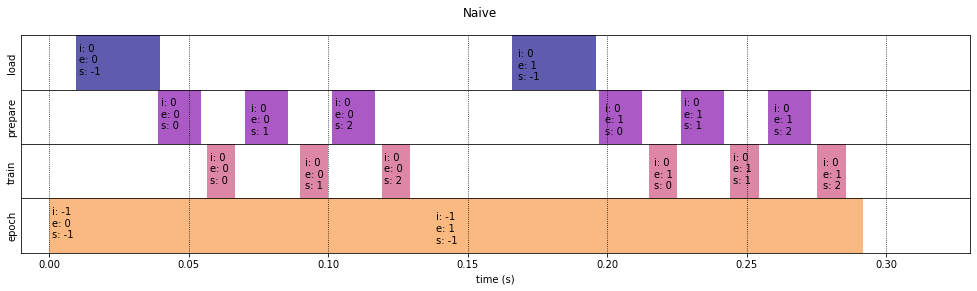

In [6]:
draw_timeline(iterate(TimeMeasuredDataset()), "Naive", 0.33)

With this plot, you see that performing a training step require that:
- you load the data in memory,
- you prepare the data,
- and then use your data for training.

However, in a naive synchronous implementation like here, while your pipeline is preparing the data, your model is sitting idle. 
Conversely, while your model is training, the input pipeline is sitting idle.
The training step time is thus the sum of all, loading, preparing and training time.

The next sections build on this input pipeline, illustrating best practices for designing performant TensorFlow input pipelines.

### Prefetching

Prefetching overlaps the preprocessing and model execution of a training step.
While the model is executing training step `s`, the input pipeline is preparing the data for step `s+1`.
Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract and transform the data.

The `tf.data` API provides the `tf.data.Dataset.prefetch` transformation.
It can be used to decouple the time when data is produced from the time when data is consumed.
In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested.
The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
You could either manually tune this value, or set it to `tf.data.experimental.AUTOTUNE` which will prompt the
`tf.data` runtime to tune the value dynamically at runtime.

Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer."

In [7]:
def get_prefetched_dataset():
    return TimeMeasuredDataset().prefetch(tf.data.experimental.AUTOTUNE)

Execution time: 0.22894737899696338


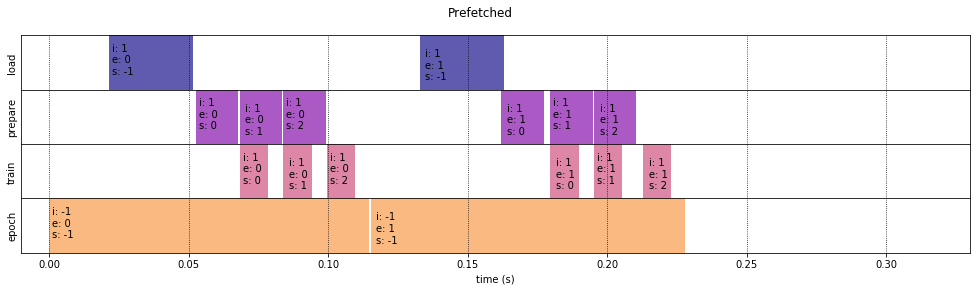

In [8]:
draw_timeline(iterate(get_prefetched_dataset()), "Prefetched", 0.33)

This time you can see that while the training step is running for sample 0, the input pipeline is preparing the data for the sample 1, and so on.

### Parallelize data extraction

In a real-world setting, the input data may be stored remotely (for example, GCS or HDFS).
A dataset pipeline that works well when reading data locally might become bottlenecked on I/O when reading data remotely because of the following differences between local and remote storage:

*   **Time-to-first-byte:** Reading the first byte of a file from remote storage can take orders of magnitude longer than from local storage.
*   **Read throughput:** While remote storage typically offers large aggregate bandwidth, reading a single file might only be able to utilize a small fraction of this bandwidth.

In addition, once the raw bytes are read into memory, it may also be necessary to deserialize and/or decrypt the data (e.g. [protobuf](https://developers.google.com/protocol-buffers/)), which requires additional computation.
This overhead is present irrespective of whether the data is stored locally or remotely, but can be worse in the remote case if data is not prefetched effectively.

To mitigate the impact of the various data extraction overheads, the `tf.data.Dataset.interleave` transformation can be used to parallelize the data loading step, interleaving the contents of other datasets (such as data file
readers).
The number of datasets to overlap can be specified by the `cycle_length` argument, while the level of parallelism can be specified by the `num_parallel_calls` argument. Similar to the `prefetch` transformation, the `interleave` transformation supports `tf.data.experimental.AUTOTUNE` which will delegate the decision about what level of parallelism to use to the `tf.data` runtime.

### Flat map

In the first example, do not use `tf.data.Dataset.interleave` but the `tf.data.Dataset.flat_map`.
According to the documentation of the `interleave` transformation:
> If you set `cycle_length` to 1, this transformation will handle one input element at a time, and will produce identical results to `tf.data.Dataset.flat_map`


Execution time: 0.5271927850008069


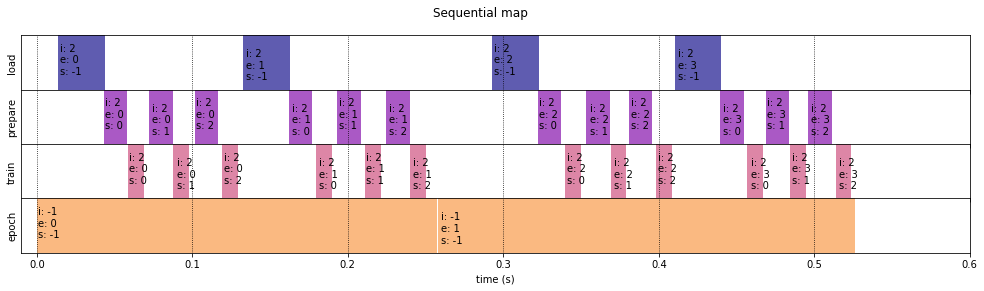

In [9]:
def get_flatmap_multi_dataset():
    return tf.data.Dataset.range(2).flat_map(TimeMeasuredDataset)  # Concatenate the samples of two datasets

draw_timeline(iterate(get_flatmap_multi_dataset()), "Sequential map", 0.6)

### Sequential interleave

For the second example, use the `tf.data.Dataset.interleave` method with its default values.

Execution time: 0.5577869720000308


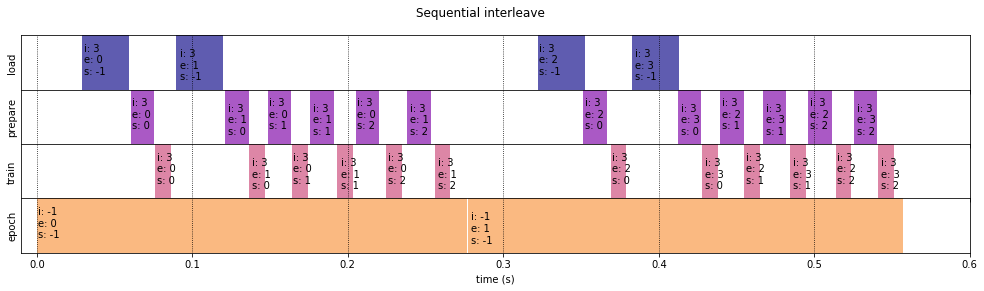

In [10]:
def get_interleaved_multi_dataset():
    return tf.data.Dataset.range(2).interleave(TimeMeasuredDataset)  # Interleave the samples of two datasets

draw_timeline(iterate(get_interleaved_multi_dataset()), "Sequential interleave", 0.6)

This plot allows to exhibit the behavior of the `interleave` transformation, fetching samples alternatively from the two datasets available. However, no performance improvement is perceptible.

### Parallel interleave

This last example, use the `num_parallel_calls` argument of the `interleave` method.
This allow it to load multiple dataset in parallel, reducing the time required for loading data in memory.

Execution time: 0.3004580509987136


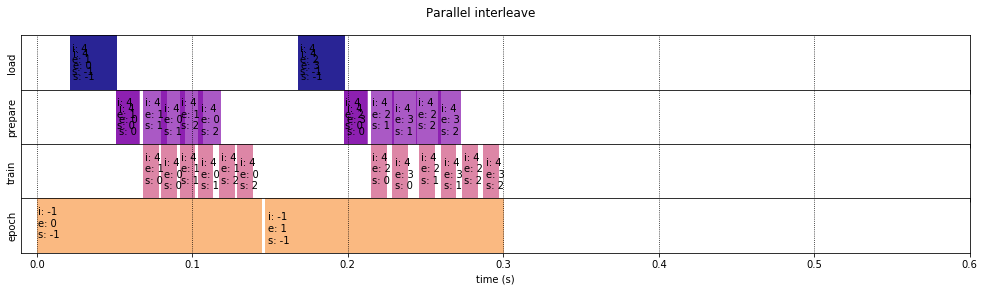

In [11]:
def get_parallel_interleaved_dataset():
    return tf.data.Dataset.range(2).interleave(
        TimeMeasuredDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

draw_timeline(iterate(get_parallel_interleaved_dataset()), "Parallel interleave", 0.6)

This time, the loading steps of the two dataset are parallelized, reducing the global data processing time.

### Parallelize data transformation

When preparing data, input elements may need to be pre-processed.
To this end, the `tf.data` API offers the `tf.data.Dataset.map` transformation, which applies a user-defined function to each element of the input dataset.
Because input elements are independent of one another, the pre-processing can be parallelized across multiple CPU cores.
To make this possible, similarly to the `prefetch` and `interleave` transformations, the `map` transformation provides the `num_parallel_calls` argument to specify the level of parallelism.

Choosing the best value for the `num_parallel_calls` argument depends on your hardware, characteristics of your training data (such as its size and shape), the cost of your map function, and what other processing is happening on the CPU at the same time.
A simple heuristic is to use the number of available CPU cores.
However, as for the `prefetch` and `interleave` transformation, the `map` transformation supports `tf.data.experimental.AUTOTUNE` which will delegate the decision about what level of parallelism to use to the `tf.data` runtime.

In [12]:
def mapped_function(s, t, x):
    def _mapped(steps, times, sample):
        # Do some hard pre-processing
        map_enter = time.perf_counter()
        time.sleep(0.02)
        map_elapsed = time.perf_counter() - map_enter
        
        # Record the time elapsed in the mapped function
        return (
            tf.concat((steps, [["map"]]), axis=0),
            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
            tf.concat((sample, [sample[-1]]), axis=0)
        )
    # Use a tf.py_function to prevent auto-graph from compiling the method
    # This is only necessary in this example case, to get execution time
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

#### Sequential mapping

Start by using the `map` transformation without parallelism as a baseline example.

Execution time: 0.4407816599996295


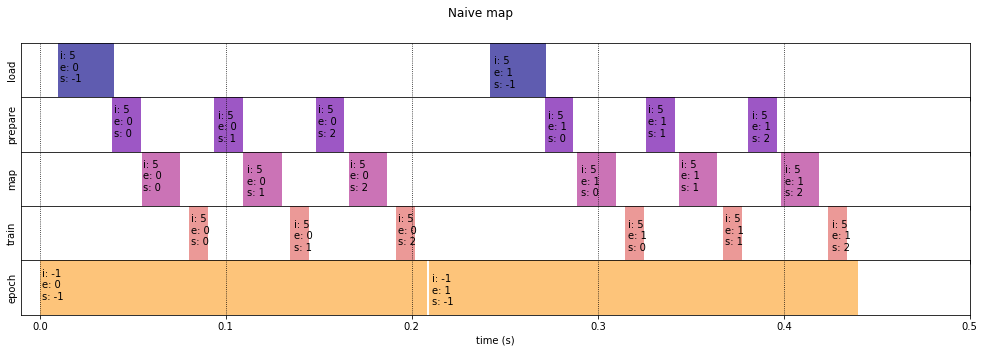

In [13]:
def get_naive_map_dataset():
    return TimeMeasuredDataset().map(mapped_function)

draw_timeline(iterate(get_naive_map_dataset()), "Naive map")

As for the [naive approach](#The-naive-approach), here the times spent for loading, preparing, pre-processing (mapping) and training steps sum together for a single iteration.

#### Parallel mapping

Now, use the same pre-processing method but applying it in parallel on multiple samples.

Execution time: 0.28275307600051747


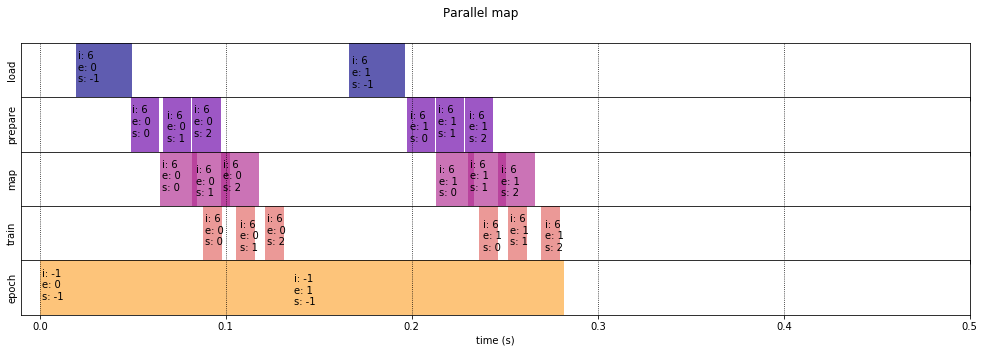

In [14]:
def get_parallel_map_dataset():
    return TimeMeasuredDataset().map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

draw_timeline(iterate(get_parallel_map_dataset()), "Parallel map")

Now, you can see on the plot that the pre-processing steps can overlap allowing to reduce the overall time for a single iteration.

### Vectorizing mapping

Invoking the user-defined function passed into the `map` transformation has overhead related to scheduling and executing the user-defined function.
We recommend vectorizing the user-defined function (that is, have it operate over a batch of inputs at once) and apply the `batch` transformation _before_ the `map` transformation.

To apply this change to our running example, define a new parsing function, acting on a batch of serialized examples, and call it after batching our dataset.

Execution time: 0.9237779250033782


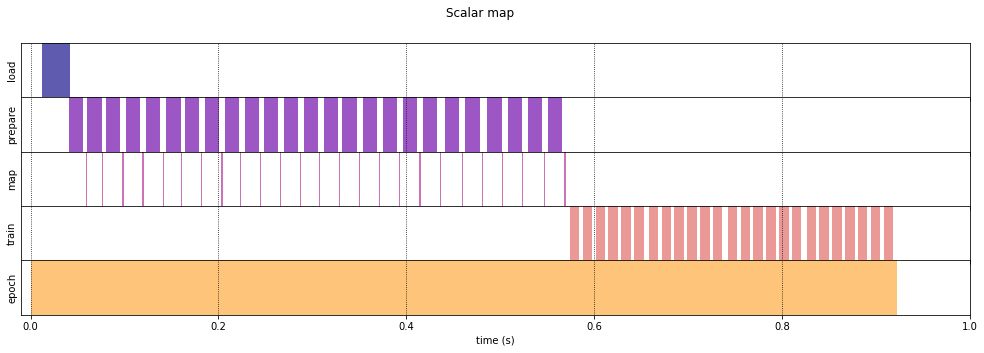

In [15]:
_batch_map_num_items = 25

def scalar_mapped_function(s, t, x):
    def _mapped(steps, times, sample):
        map_enter = time.perf_counter()
        time.sleep(0.001)
        map_elapsed = time.perf_counter() - map_enter
        return (
            tf.concat((steps, [["map"]]), axis=0),
            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
            tf.concat((sample, [sample[-1]]), axis=0)
        )
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

def get_scalar_mapped_dataset():
    return TimeMeasuredDataset(
        num_samples=_batch_map_num_items
    ).map(
        scalar_mapped_function
    ).batch(
        _batch_map_num_items,
    ).unbatch()

draw_timeline(iterate(get_scalar_mapped_dataset(), 1), "Scalar map", 1, annotate=False)

In this example, you can see that the mapped function is applied for each sample. While this function is very fast, it has some overhead that impact the time performance.

Execution time: 0.8278999009999097


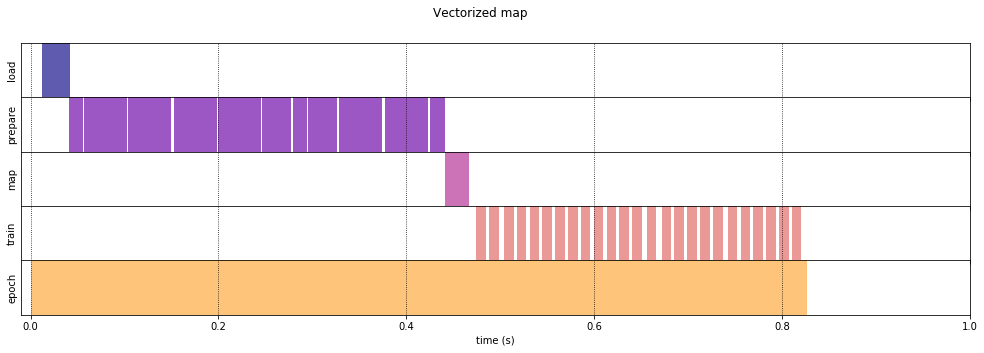

In [16]:
def vectorized_mapped_function(s, t, x):
    def _mapped(steps, times, sample):
        map_enter = time.perf_counter()
        time.sleep(0.001 * sample.shape[0])
        map_elapsed = time.perf_counter() - map_enter
        result = (
            tf.concat((steps, tf.tile([[["map"]]], [sample.shape[0], 1, 1])), axis=1),
            tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [sample.shape[0], 1, 1])), axis=1),
            tf.concat((sample, tf.tile([[sample[:][-1][0]]], [sample.shape[0], 1, 1])), axis=1)
        )
        return result
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

def get_vectorized_mapped_dataset():
    return TimeMeasuredDataset(
        num_samples=_batch_map_num_items
    ).batch(
        _batch_map_num_items,
    ).map(vectorized_mapped_function).unbatch()

draw_timeline(iterate(get_vectorized_mapped_dataset(), 1), "Vectorized map", 1, annotate=False)

This time, the mapped function is called once and applies to a batch of sample. While the function takes more time to execute, the overhead appear only once, improving the overall time performance.

### Caching

The `tf.data.Dataset.cache` transformation can cache a dataset, either in memory or on local storage.
This will prevent some operations (like data loading and preparation) to be executed for each epoch.

Execution time: 0.5561782009972376


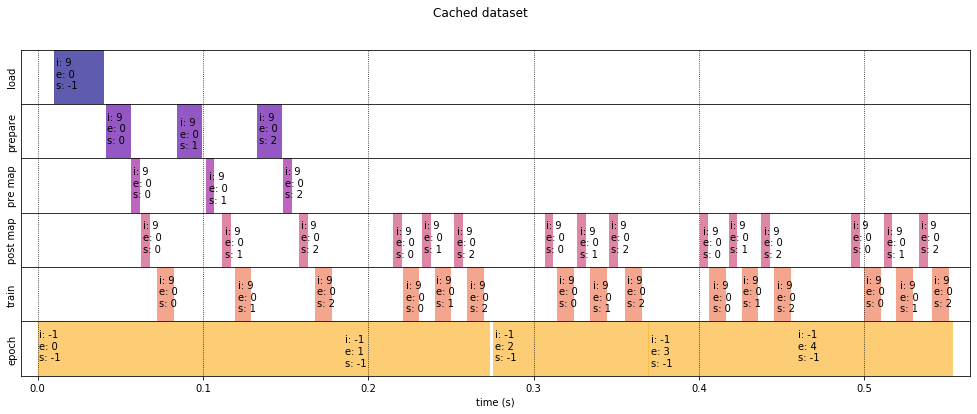

In [17]:
def cache_mapped_pre_function(s, t, x):
    def _mapped(steps, times, sample):
        map_enter = time.perf_counter()
        time.sleep(0.005)
        map_elapsed = time.perf_counter() - map_enter
        
        # Record the time elapsed in the mapped function
        return (
            tf.concat((steps, [["pre map"]]), axis=0),
            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
            tf.concat((sample, [sample[-1]]), axis=0)
        )
    # Use a tf.py_function to prevent auto-graph from compiling the method
    # This is only necessary in this example case, to get execution time
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

def cache_mapped_post_function(s, t, x):
    def _mapped(steps, times, sample):
        # Do some hard pre-processing
        map_enter = time.perf_counter()
        time.sleep(0.005)
        map_elapsed = time.perf_counter() - map_enter
        
        # Record the time elapsed in the mapped function
        return (
            tf.concat((steps, [["post map"]]), axis=0),
            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
            tf.concat((sample, [sample[-1]]), axis=0)
        )
    # Use a tf.py_function to prevent auto-graph from compiling the method
    # This is only necessary in this example case, to get execution time
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

def get_cached_dataset():
    return TimeMeasuredDataset().map(
        cache_mapped_pre_function
    ).cache(
    ).map(
        cache_mapped_post_function
    )

draw_timeline(iterate(get_cached_dataset(), 5), "Cached dataset")

When you cache a dataset, the transformations before the `cache` one (like the dataset loading and preparation) are executed only during the first epoch.
The next epochs will reuse the data persisted by the `cache` transformation.

If the user-defined function passed into the `map` transformation is expensive, apply the cache transformation after the `map` transformation as long as the resulting dataset can still fit into memory or local storage.
If the user-defined function increases the space required to store the dataset beyond the cache capacity, consider pre-processing your data before your training job to reduce resource usage.

### Map and memory bound operations

A number of transformations, including `interleave`, `prefetch`, and `shuffle`,
maintain an internal buffer of elements. If the user-defined function passed
into the `map` transformation changes the size of the elements, then the
ordering of the map transformation and the transformations that buffer elements
affects the memory usage. In general, we recommend choosing the order that
results in lower memory footprint, unless different ordering is desirable for
performance.

#### Caching partial computations

As seen above, it is recommended to cache you dataset after the `map` transformation except if this transformation make the data too big to fit in memory.
A trade-off can be achieved if your mapped function can be split in two parts: a time consuming one and a memory consuming part.
In this case, you can chain your transformations like below:

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

This way, your time consuming part is only executed during the first epoch, while limiting your memory footprint avoiding big data chunks to be persisted in memory.

## Best practice summary

Here is a summary of the best practices for designing performant TensorFlow
input pipelines:

*   [Use the `prefetch` transformation](#Pipelining) to overlap the work of a producer and consumer.
*   [Parallelize the data reading transformation](#Parallelize-data-extraction) using the `interleave` transformation.
*   [Parallelize the `map` transformation](#Parallelize-data-transformation) by setting the `num_parallel_calls` argument.
*   [Vectorize user-defined functions](#Map-and-batch) passed in to the `map` transformation
*   [Use the `cache` transformation](#Caching) to cache data in memory during the first epoch
*   [Reduce memory usage](#Memory-bound-transformations) when applying the `interleave`, `prefetch`, and `shuffle` transformations.